In [1]:
import findspark
findspark.init()

In [2]:
import numpy as np
import pyspark
from pyspark.sql import SparkSession, Row
from pyspark.sql.types import *
import pyspark.sql.functions as F
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, to_timestamp, unix_timestamp, to_date, to_date, col, year, month

In [3]:
spark = pyspark.sql.SparkSession.builder.master("local").getOrCreate()

21/12/07 22:17:10 WARN Utils: Your hostname, LAPTOP-T2T1G8JL resolves to a loopback address: 127.0.1.1; using 172.22.10.85 instead (on interface eth0)
21/12/07 22:17:10 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
21/12/07 22:17:12 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
21/12/07 22:17:13 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
21/12/07 22:17:13 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
21/12/07 22:17:13 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.
21/12/07 22:17:13 WARN Utils: Service 'SparkUI' could not bind on port 4043. Attempting port 4044.
21/12/07 22:

In [4]:
# Let's define our schema
schema = StructType([\
    StructField("date", DateType(), True),\
    StructField("time", StringType(), True),\
    StructField("company", StringType(), True),\
    StructField("level", StringType(), True),\
    StructField("title", StringType(), True),\
    StructField("totalyearlycompensation", IntegerType(), False),\
    StructField("location", StringType(), True),\
    StructField("yearsofexperience", FloatType(), False),\
    StructField("yearsatcompany", FloatType(), False),\
    StructField("tag", StringType(), True),\
    StructField("basesalary", IntegerType(), False),\
    StructField("stockgrantvalue", IntegerType(), False),\
    StructField("bonus", IntegerType(), False),\
    StructField("gender", StringType(), True),\
    StructField("cityid", StringType(), True),\
    StructField("dmaid", StringType(), True),\
    StructField("race", StringType(), True),\
    StructField("education", StringType(), True)])

# Load and parse the data file, converting it to a DataFrame.
data = spark.read.format("csv")\
    .option("header", "false")\
    .option("delimiter", "\t")\
    .schema(schema)\
    .load("data/seperated_time_data/cleaned.txt")

+----------+--------+---------+-----+--------------------+-----------------------+-----------------+-----------------+--------------+---+----------+---------------+-----+------+------+-----+----+---------+
|      date|    time|  company|level|               title|totalyearlycompensation|         location|yearsofexperience|yearsatcompany|tag|basesalary|stockgrantvalue|bonus|gender|cityid|dmaid|race|education|
+----------+--------+---------+-----+--------------------+-----------------------+-----------------+-----------------+--------------+---+----------+---------------+-----+------+------+-----+----+---------+
|2017-06-07|   11:33|   ORACLE|   L3|     Product Manager|                 127000| Redwood City, CA|              1.5|           1.5| NA|    107000|          20000|10000|    NA|  7392|  807|  NA|       NA|
|2017-06-10|   17:11|     EBAY| SE 2|   Software Engineer|                 100000|San Francisco, CA|              5.0|           3.0| NA|    141907|              0|    0|    NA

## Creating new Column for Month/Year to allow for Grouping

In [32]:
# Creating two new columns for year and month (to allow us to group by month)

adjustedDf = data.withColumn("date", to_date(col("date"), "yyyy-MM-dd"))\
    .withColumn('month', month("date"))

adjustedDf2 = adjustedDf.withColumn("date", to_date(col("date"), "yyyy-MM-dd"))\
    .withColumn('year', year("date"))

In [57]:
new_data = adjustedDf2.withColumn(
    "date",
    F.date_format(F.expr("make_date(year, month, 1)"), "MM/dd/yyyy")
)

## Impact of Covid-19 on all Earnings

In [75]:
selected_data = new_data.select(to_date(col("date"),"MM/dd/yyyy").alias("date"), 'totalyearlycompensation', 'basesalary', 'bonus')

In [76]:
grouped_data = selected_data.groupby('date').mean('totalyearlycompensation', 'basesalary', 'bonus')

In [77]:
rounded_data1 = grouped_data.withColumn("avg(basesalary)", F.round(grouped_data["avg(basesalary)"], 2))
rounded_data2 = rounded_data1.withColumn("avg(totalyearlycompensation)", F.round(rounded_data1["avg(totalyearlycompensation)"], 2))
rounded_data3 = rounded_data2.withColumn("avg(bonus)", F.round(rounded_data2["avg(bonus)"], 2))

In [78]:
tyc_data = rounded_data3.select('date', 'avg(totalyearlycompensation)').toPandas()
salary_data = rounded_data3.select('date', 'avg(basesalary)').toPandas()
bonus_data = rounded_data3.select('date', 'avg(bonus)').toPandas()

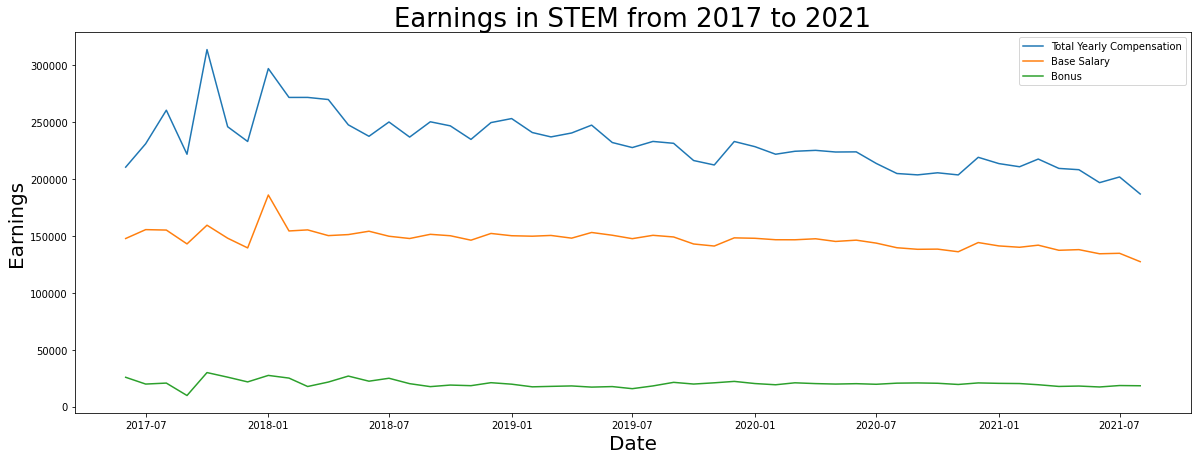

In [88]:
fig, ax = plt.subplots(figsize=(20, 7))
tyc_data.plot(x="date", ax=ax)
salary_data.plot(x="date", ax=ax)
bonus_data.plot(x="date", ax=ax)
plt.title("Earnings in STEM from 2017 to 2021", fontsize=26)
plt.xlabel("Date", fontsize=20)
plt.ylabel("Earnings", fontsize=20)
plt.legend(labels=["Total Yearly Compensation", "Base Salary", "Bonus"], loc='best')
plt.show()

# Identifying the number of Records created Each Month

In [80]:
selected_data = new_data.select(to_date(col("date"),"MM/dd/yyyy").alias("date"))

In [85]:
grouped_data = selected_data.groupby('date').count().toPandas()

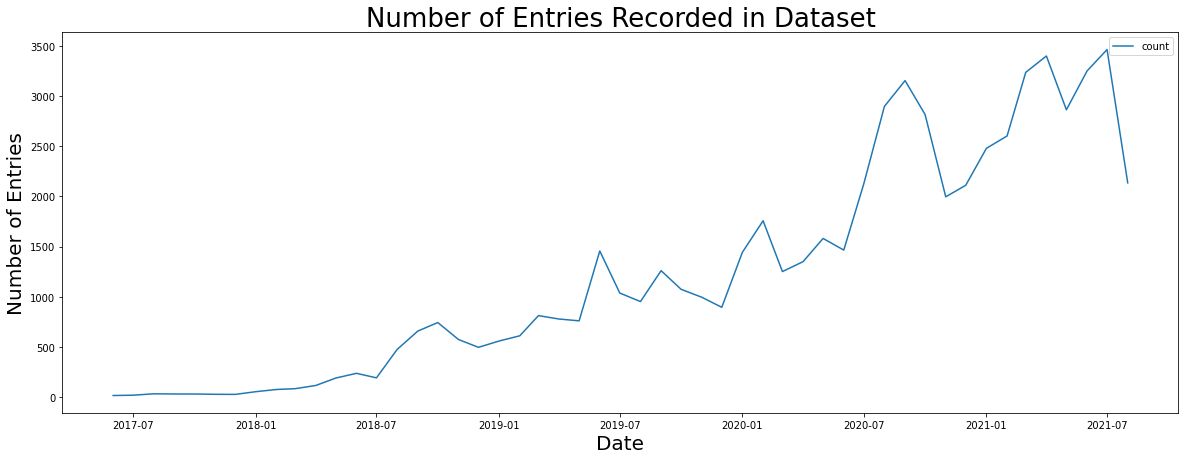

In [87]:
fig, ax = plt.subplots(figsize=(20, 7))
grouped_data.plot(x="date", ax=ax)
plt.title("Number of Entries Recorded in Dataset", fontsize=26)
plt.xlabel("Date", fontsize=20)
plt.ylabel("Number of Entries", fontsize=20)
plt.show()